In [1]:
import os
# running from Root directory
os.chdir("..")

In [124]:
from motif_search_main import load_network_from_args
from utils.export_import import import_results
from utils.logs import log_motif_criteria_args, log_motif_results, log_sub_graph_args, log_randomizer_args, \
    log_polarity_motif_results
from utils.types import MotifCriteriaArgs, MotifType, MotifName
import matplotlib.pyplot as plt
import networkx as nx
import igraph as ig
from typing import Union


In [107]:
data = import_results('results/pol_test.bin')
args = data['args']
motifs = data['motifs']
polarity_motifs = data['polarity_motifs']
network = load_network_from_args(args)

log_motif_criteria_args(MotifCriteriaArgs(**vars(args)))
log_sub_graph_args(args)
log_randomizer_args(args)
log_motif_results(motifs, network)
log_polarity_motif_results(polarity_motifs)

Network file name: s1_data.xlsx
Filtering Neurons with polarity: ['+', '-']
Filtering Neurons with primary neurotransmitter: ['Glu', 'GABA', 'ACh', 0]
Polarity E/I ratio (before filtering): 3.122

Network properties:
	Neurons: 283
	Neurons with a Synapse: 283
	Synapses in the network: 11650

	Participating Nodes are neurons in a tuple with at least: 5 synapses
	Synapses in the graph: 9515
	Nodes: 259
	Edges: 661
	Average clustering coefficient: 0.06
	Average shortest path (undirected): 2.038
	Density: 0.01
	Polarity E/I ratio: 3.721
	Degree: Mean: 5.104 Std: 4.445 Median: 4.0 Max: 25 (node: RIAL)
	In-Degree: Mean: 2.552 Std: 3.973 Median: 1.0 Max: 23 (node: AVBL)
	Out-Degree: Mean: 2.552 Std: 2.283 Median: 2.0 Max: 13 (node: RIML)

Motif criteria:
	alpha: 0.01
	use uniqueness: False
	uniqueness threshold: 3
	frequency threshold: 0.1

Sub Graph search using Algorithm: mfinder_i
Sub Graph search using k: 3
Allow self loops: False
Doing full Motif-Search: True

Randomizer: using markov_ch

In [19]:
def plot_motif_distribution(motifs_, anti_motifs_, none_motifs_):
    sizes = [len(motifs_), len(anti_motifs_), len(none_motifs_)]
    labels = [MotifType.motif.value, MotifType.anti_motif.value, MotifType.none.value]

    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%')
    total = sum(sizes)
    for s,l in zip(sizes, labels):
        print(f'{l}: {s}/{total}')

In [121]:
def plot_motifs_z(motifs_list, motif_type, top=10):
    reverse_sort = True if motif_type == MotifType.motif else False
    sorted_by_z = sorted(motifs_list, key=lambda m: m.motif_criteria.z_score, reverse=reverse_sort)
    sorted_by_z = sorted_by_z[:top]

    z_scores = [abs(round(m.motif_criteria.z_score, 2)) for m in sorted_by_z]
    ids_ = [str(m.id) for m in sorted_by_z]
    n_reals = [m.n_real for m in sorted_by_z]
    n_rands = [m.motif_criteria.n_rand for m in sorted_by_z]

    plt.figure()
    plt.title(f'Z-score of {motif_type.value}s')
    plt.ylabel('Z-score')
    plt.xlabel('Motif id')

    plt.bar(ids_,z_scores)
    for x, y, n_real, n_rand in zip(ids_, z_scores, n_reals, n_rands):
       plt.text(x, y, f'n_real: {n_real}\nn_rand: {n_rand}', ha='center', fontsize=7.5)
    plt.show()
    
    # plot of the graphs
    num_of_graphs = len(sorted_by_z)
    fig, ax = plt.subplots(nrows=1, ncols=num_of_graphs, figsize=(num_of_graphs*2, 2))
    for idx, motif in enumerate(sorted_by_z):
        graph = nx.DiGraph(motif.role_pattern)
        h = ig.Graph.from_networkx(graph)
        layout = h.layout_circle()
        ax_ = ax[idx]
        title = f'{motif.name.value}-{motif.id}' if motif.name.value != MotifName.na else motif.id
        ax_.set_title(title)
        ig.plot(h, layout=layout, target=ax_, vertex_label=list(graph.nodes))

In [110]:
def plot_motif_roles(motif, top=5):
    roles = motif.node_roles.keys()
    num_of_roles = len(roles)
    fig, ax = plt.subplots(nrows=1, ncols=num_of_roles, figsize=(num_of_roles*4, 4))
    
    title = motif.name.value if motif.name.value != MotifName.na else motif.id
    fig.suptitle(f'Motif - {title}: node roles')
    fig.text(0.5, 0.01, 'Node name', ha='center', va='center')
    fig.text(0.1, 0.5, 'Freqency', ha='center', va='center', rotation='vertical')

    for idx, role in enumerate(roles):
        nodes = list(motif.node_roles[role])[:top]
        freqs = list(motif.node_roles[role].values())[:top]
        ax_ = ax[idx]
        ax_.bar(nodes, freqs)
        ax_.set_title(f'role: {role}')
        

In [172]:
def node_properties(node: Union[str, int], motifs_list):
    print(f'Node {node} properties:')

    if isinstance(node, str):
        node_idx = network.neuron_names.index(node)
    else:
        node_idx - node

    print(f'Degree: {network.graph.degree[node_idx]}')
    print(f'Out Degree: {network.graph.out_degree[node_idx]}')
    print(f'In Degree: {network.graph.in_degree[node_idx]}')
    print(f'Clustering coefficient: {round(nx.average_clustering(network.graph, nodes=[node_idx]), 3)}')

    
    node_freq_in_motifs = {str(motif.id): motif.node_appearances.get(node, 0) for motif in motifs_list}
    # filter only nodes that appear at least 1
    node_freq_in_motifs = {x:y for x,y in node_freq_in_motifs.items() if y!=0}
    
    freq_sorted = dict(sorted(node_freq_in_motifs.items(), key=lambda ele: ele[1], reverse=True))
    plt.figure()
    plt.title(f'Appearance of node: {node} in sub-graphs')
    plt.ylabel('Frequency')
    plt.xlabel('Sub-graph id')

    plt.bar(freq_sorted.keys(), freq_sorted.values())
    plt.show()

motif: 6/13
anti-motif: 3/13
none: 4/13


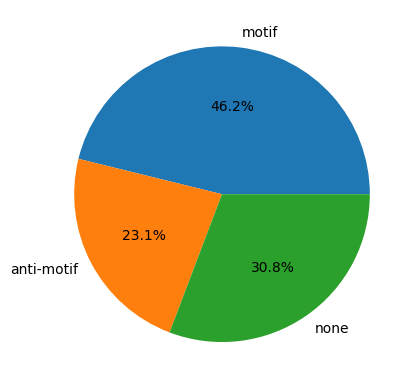

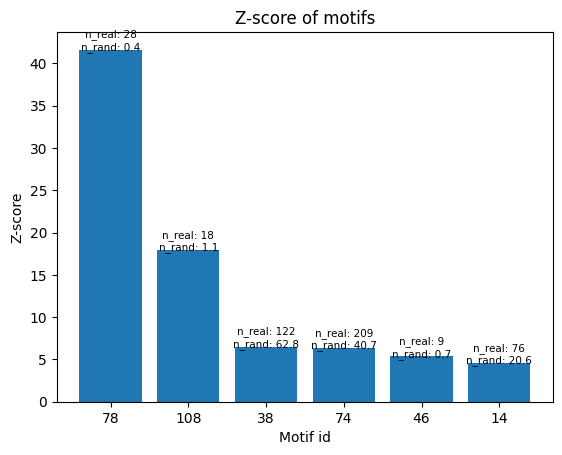

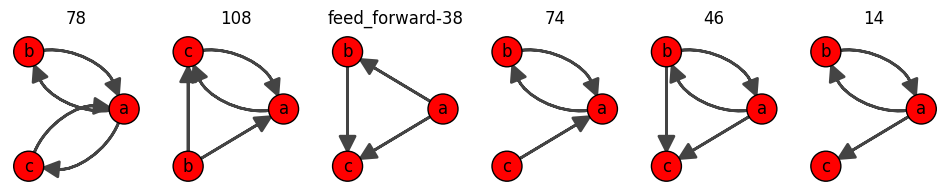

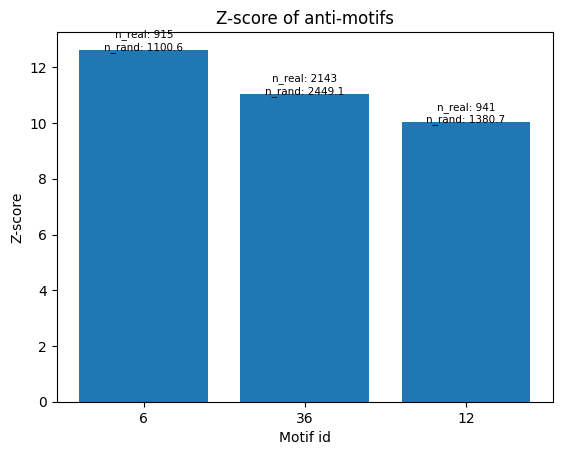

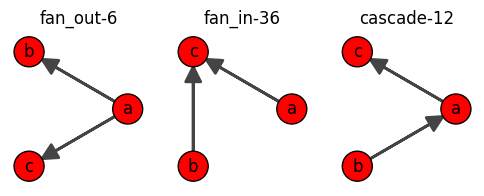

In [173]:
motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.motif]
anti_motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.anti_motif]
none_motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.none]

plot_motif_distribution(motifs_, anti_motifs_, none_motifs_)
plot_motifs_z(motifs_, MotifType.motif)
plot_motifs_z(anti_motifs_, MotifType.anti_motif)

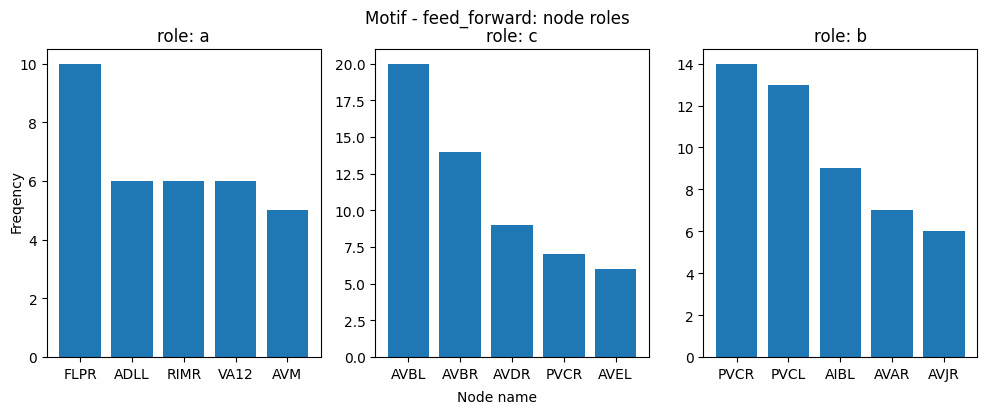

In [174]:
plot_motif_roles(motifs[38])

Node AVBR properties:
Degree: 20
Out Degree: 0
In Degree: 20
Clustering coefficient: 0.037


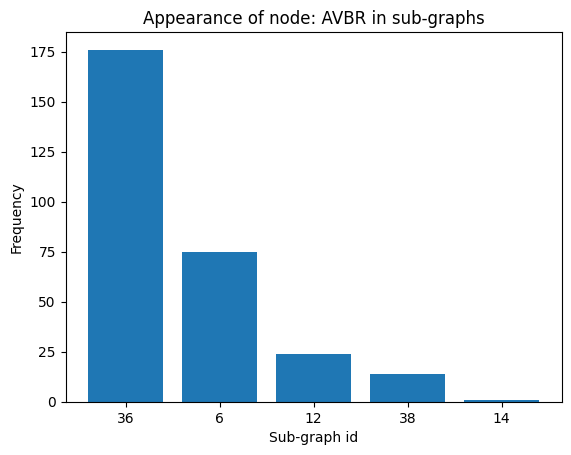

In [175]:
node_properties('AVBR', motifs.values())